In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV


In [2]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [3]:
# Load the training data
train_full_df = pd.read_csv('../data/train.csv').drop('Id', axis=1)
train_full_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Create an EdaToolbox object

In [4]:
# Initialize the EdaToolbox
target_col = 'SalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

## First check the distribution of the target column

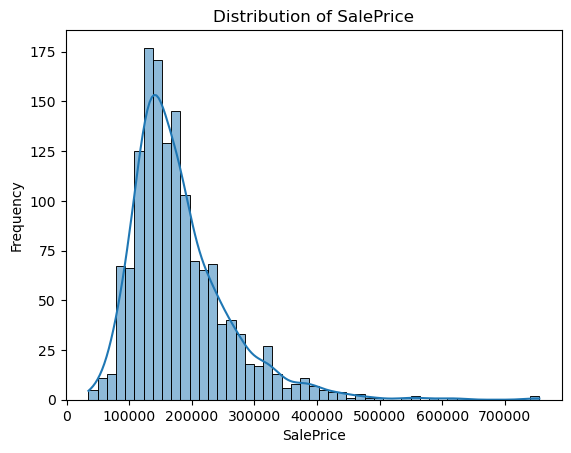

In [5]:
# Plot target column distribution
eda.plot_regression_target_column_distribution()

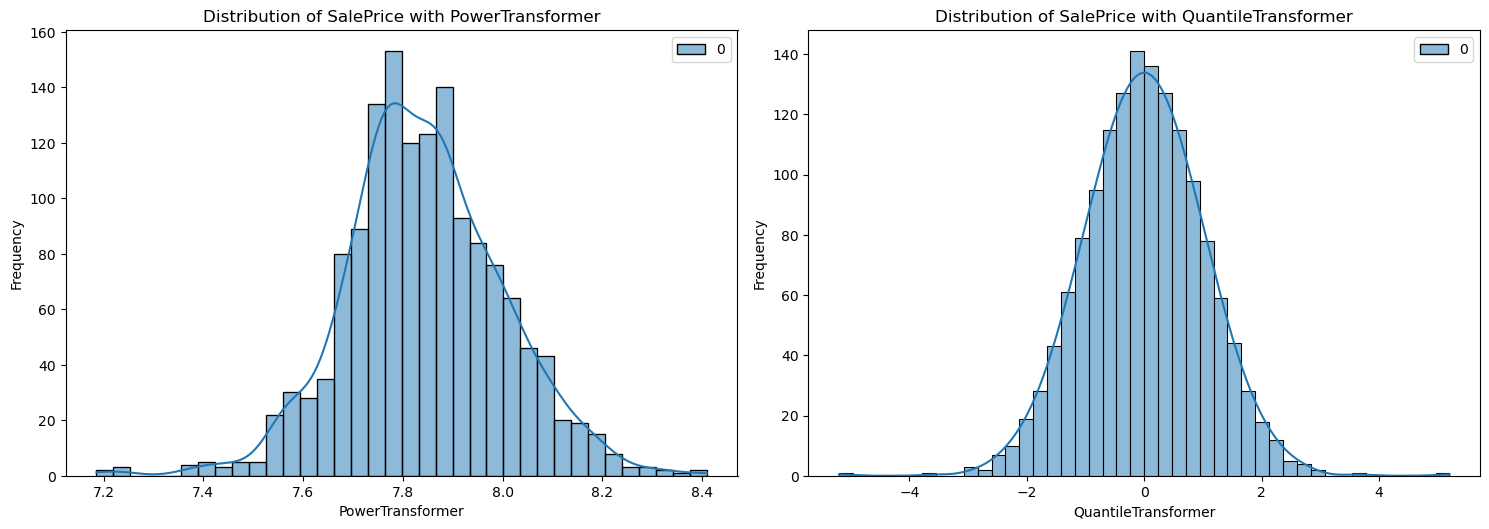

In [6]:
# It is not normally distributed. It is skewed. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}
eda.plot_regression_target_column_distribution_variations(target_transformation_dict)

In [7]:
# Create a dict of models for preliminary testing
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV()
}


In [8]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV
PowerTransformer,0.055527,0.055469,0.171965,0.171965,0.054703,0.054711,0.055237
QuantileTransformer,0.340366,0.339772,1.102105,0.881407,0.334722,0.335765,0.337834


In [9]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good scores with very basic encoding and no feature selection
eda.target_transformer = target_transformation_dict['PowerTransformer']

## Prepare the data for feature selection

## Check which colums can be pruned

In [10]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
Utilities,object,0.999315,AllPub,2,0,0.0,"Index(['AllPub', 'NoSeWa'], dtype='object', na..."
Street,object,0.995890,Pave,2,0,0.0,"Index(['Pave', 'Grvl'], dtype='object', name='..."
Condition2,object,0.989726,Norm,8,0,0.0,"Index(['Norm', 'Feedr', 'Artery', 'RRNn', 'Pos..."
RoofMatl,object,0.982192,CompShg,8,0,0.0,"Index(['CompShg', 'Tar&Grv', 'WdShngl', 'WdSha..."
Heating,object,0.978082,GasA,6,0,0.0,"Index(['GasA', 'GasW', 'Grav', 'Wall', 'OthW',..."
...,...,...,...,...,...,...,...
YearBuilt,int64,0.045890,2006,112,0,0.0,"Index([2006, 2005, 2004, 2007, 2003, 1976, 197..."
TotalBsmtSF,int64,0.025342,0,721,0,0.0,"Index([0, 864, 672, 912, 1040, 816, 768, 728, ..."
LotArea,int64,0.017123,7200,1073,0,0.0,"Index([7200, 9600, 6000, 9000, 8400, 10800, 16..."
1stFlrSF,int64,0.017123,864,753,0,0.0,"Index([864, 1040, 912, 894, 848, 672, 630, 816..."


In [11]:
# Set pruning thresholds on the eda object according to column data type and cardinality
eda.prune_threshold_categorical = 0.9
eda.prune_threshold_numerical = 0.95
eda.prune_threshold_pct_missing = 0.8

## Feature analysis

In [12]:
# Frist do basic scaling and encoding to see what the correlation matrix looks like
feature_transformer = eda.get_basic_feature_transformer()
target_transformer = target_transformation_dict['PowerTransformer']
fa_df = eda.get_regression_feature_analysis_df(feature_transformer=feature_transformer, target_transformer=target_transformer)
fa_df.head()

Best RidgeCV alpha: 100.0 (R^2 score:  0.90)


c:\Users\jim\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,correlation,correlation_abs,coefficient,coefficient_abs,pval,vif,PCA1,PCA2,total
numerical__OverallQual,0.815044,0.815044,0.027309,1.000000,0.941351,4.168824,0.220375,0.024997,1.815044
ordinal_8__Neighborhood,0.740302,0.740302,0.022877,0.837704,0.948111,3.389460,0.209431,-0.021592,1.578006
numerical__GrLivArea,0.697017,0.697017,0.019406,0.710616,0.985452,140.158094,0.160928,0.289435,1.407633
numerical__1stFlrSF,0.593533,0.593533,0.014488,0.530534,0.999556,79.173839,0.151199,0.220271,1.124067
numerical__GarageCars,0.680203,0.680203,0.011568,0.423594,0.978991,6.236798,0.201126,0.056287,1.103798


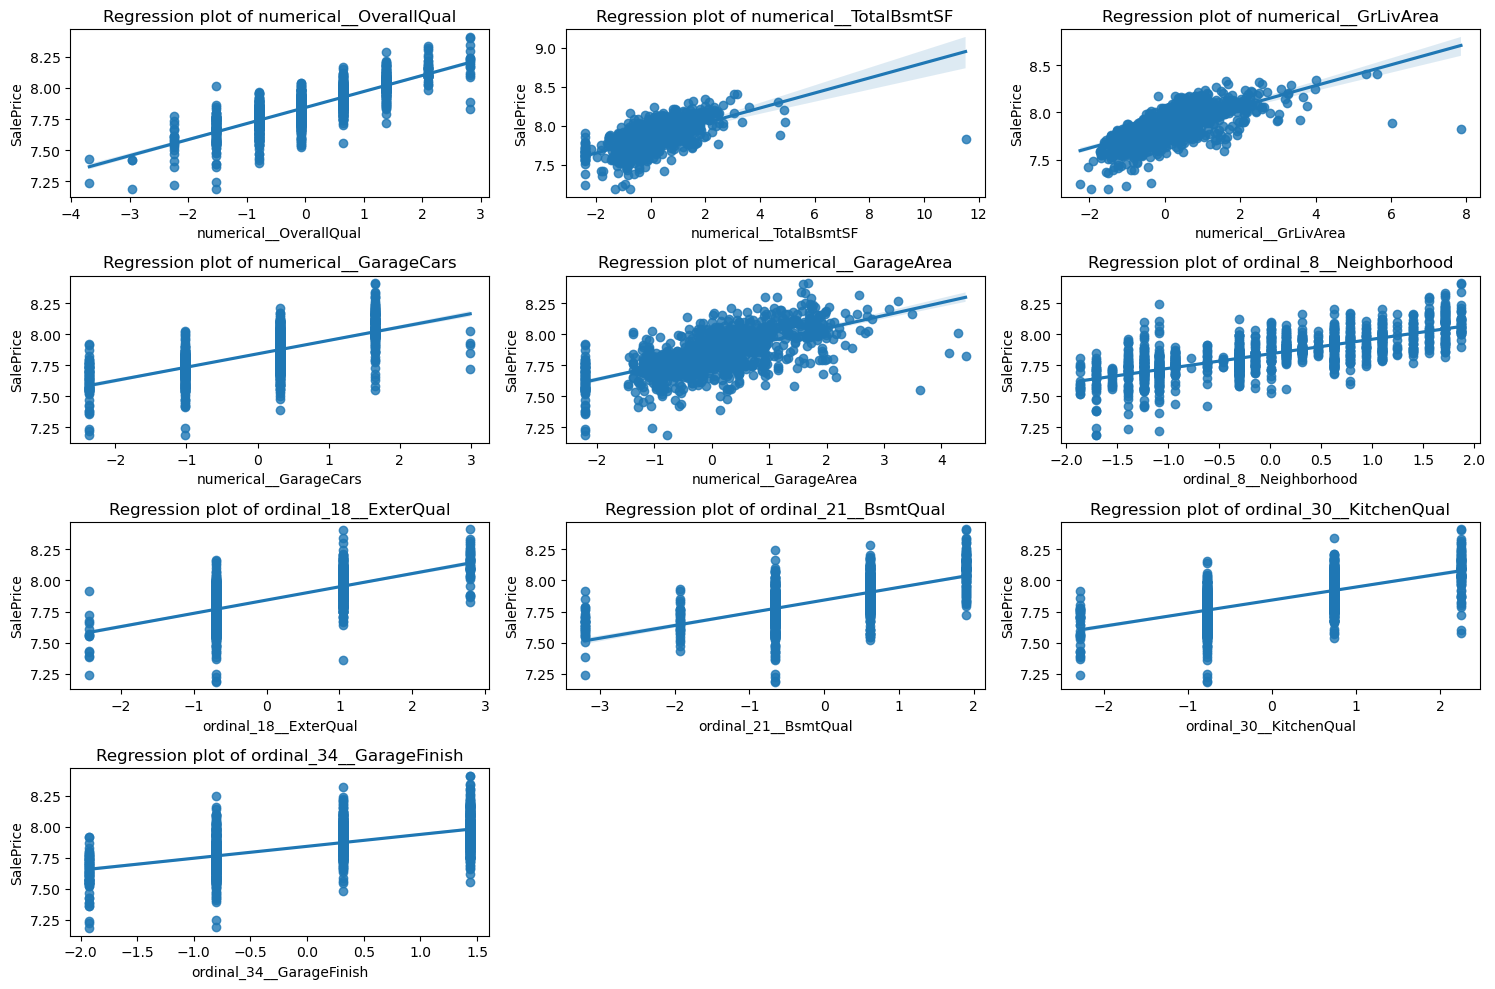

In [13]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(feature_transformer, target_transformer, corr_min=0.6)

In [14]:
# Select the features with a total score greater than 0.55
important_features_df = eda.get_regression_important_features_df(fa_df=fa_df, total_min=0.55, pval_max=1.0, vif_max=None)
important_features_df.head()

,correlation,correlation_abs,coefficient,coefficient_abs,pval,vif,PCA1,PCA2,total
numerical__OverallQual,0.815044,0.815044,0.027309,1.000000,0.941351,4.168824,0.220375,0.024997,1.815044
ordinal_8__Neighborhood,0.740302,0.740302,0.022877,0.837704,0.948111,3.389460,0.209431,-0.021592,1.578006
numerical__GrLivArea,0.697017,0.697017,0.019406,0.710616,0.985452,140.158094,0.160928,0.289435,1.407633
numerical__1stFlrSF,0.593533,0.593533,0.014488,0.530534,0.999556,79.173839,0.151199,0.220271,1.124067
numerical__GarageCars,0.680203,0.680203,0.011568,0.423594,0.978991,6.236798,0.201126,0.056287,1.103798


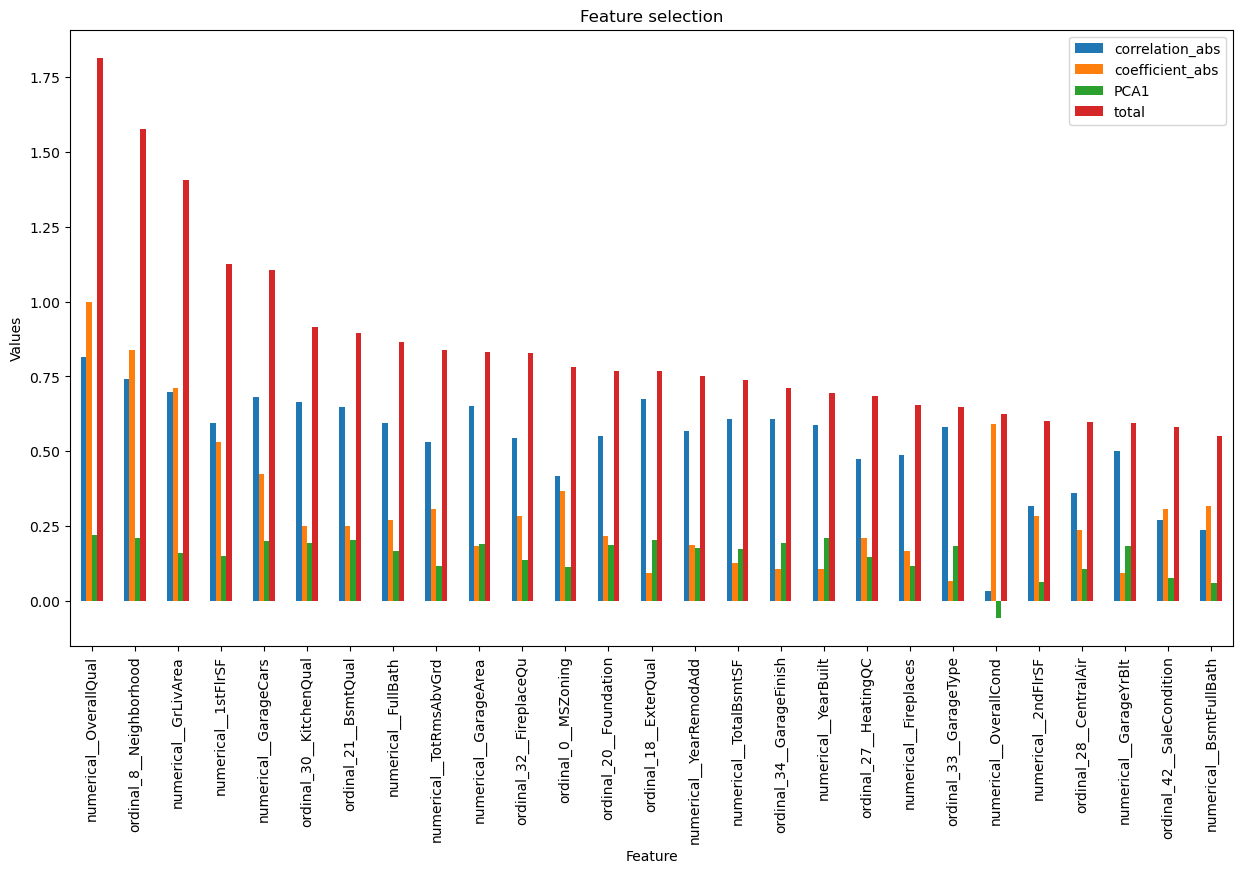

In [15]:
eda.plot_important_features(important_features_df)

In [16]:
imp_features_list = eda.get_important_features_list(important_features_df)
len(imp_features_list), imp_features_list

(27,
 ['OverallQual',
  'Neighborhood',
  'GrLivArea',
  '1stFlrSF',
  'GarageCars',
  'KitchenQual',
  'BsmtQual',
  'FullBath',
  'TotRmsAbvGrd',
  'GarageArea',
  'FireplaceQu',
  'MSZoning',
  'Foundation',
  'ExterQual',
  'YearRemodAdd',
  'TotalBsmtSF',
  'GarageFinish',
  'YearBuilt',
  'HeatingQC',
  'Fireplaces',
  'GarageType',
  'OverallCond',
  '2ndFlrSF',
  'CentralAir',
  'GarageYrBlt',
  'SaleCondition',
  'BsmtFullBath'])

In [17]:
# Check Square footage features to see what can be dropped
# GrLivArea = 1stFlrSF + 2ndFlrSF
sf_features_list = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']
sf_df = eda.df[sf_features_list]
sf_df

,GrLivArea,1stFlrSF,2ndFlrSF,TotalBsmtSF
0,1710,856,854,856
1,1262,1262,0,1262
2,1786,920,866,920
3,1717,961,756,756
4,2198,1145,1053,1145
...,...,...,...,...
1455,1647,953,694,953
1456,2073,2073,0,1542
1457,2340,1188,1152,1152
1458,1078,1078,0,1078


In [18]:
# Remove features with high VIF
features_to_remove = ['1stFlrSF', '2ndFlrSF', 'GarageArea']
imp_features_list = [value for value in imp_features_list if value not in features_to_remove]
imp_features_list

['OverallQual',
 'Neighborhood',
 'GrLivArea',
 'GarageCars',
 'KitchenQual',
 'BsmtQual',
 'FullBath',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'MSZoning',
 'Foundation',
 'ExterQual',
 'YearRemodAdd',
 'TotalBsmtSF',
 'GarageFinish',
 'YearBuilt',
 'HeatingQC',
 'Fireplaces',
 'GarageType',
 'OverallCond',
 'CentralAir',
 'GarageYrBlt',
 'SaleCondition',
 'BsmtFullBath']

In [19]:
# Now get the list of important ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(imp_features_list)
len(final_ordinal_cols), final_ordinal_cols

(12,
 ['MSZoning',
  'Neighborhood',
  'ExterQual',
  'Foundation',
  'BsmtQual',
  'HeatingQC',
  'CentralAir',
  'KitchenQual',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'SaleCondition'])

## Perform final EDA with selected features and ordinal columns

In [20]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.selected_feature_list = imp_features_list
eda.ordinal_encoding_cols = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

feature_transformer = eda.create_feature_transformer()
feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infrequent_threshold=0.95,
                                                               pct_missing_threshold=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['OverallQual',
                                                                                                     'Neighborhood',
                                                                                                     'GrLivArea',
                                                                                                     'GarageCars',
                                                                                                     'KitchenQual',
                                                                                                     'BsmtQual',
                                                                                                     'FullBath',
                                                                                                     'TotRmsAbvGrd',
                                                                                                     'FireplaceQu',
                                                                                                     'MSZoning...
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['GarageFinish']),
                                ('ordinal_12',
                                 Pipeline(memory='named_steps',
                                          steps=[('SaleCondition',
                                                  OrdinalEncoder(categories=[['AdjLand',
                                                                              'Abnorml',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial']],
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['SaleCondition'])])

In [21]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df(feature_transformer=feature_transformer, target_transformer=target_transformer)
feature_analysis_df.head()

Best RidgeCV alpha: 100.0 (R^2 score:  0.88)


,correlation,correlation_abs,coefficient,coefficient_abs,pval,vif,PCA1,PCA2,total
numerical__OverallQual,0.815044,0.815044,0.028304,0.891920,0.938043,3.794093,0.273323,0.093685,1.706964
numerical__GrLivArea,0.697017,0.697017,0.031734,1.000000,0.935424,5.121879,0.194492,0.408485,1.697017
ordinal_2__Neighborhood,0.740302,0.740302,0.024270,0.764802,0.942110,3.083055,0.260944,-0.045530,1.505104
numerical__GarageCars,0.680203,0.680203,0.018046,0.568670,0.950298,2.121788,0.234962,0.057785,1.248873
numerical__TotalBsmtSF,0.609149,0.609149,0.013797,0.434760,0.962843,1.889023,0.197221,0.106724,1.043909


# Now do model analysis for multiple regression models

In [30]:
# Reload the data just to be safe
train_full_df = pd.read_csv('../data/train.csv')

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column='SalePrice')
reg.set_column_transformer_properties(selected_feature_list=imp_features_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [31]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7))
}

In [32]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 80
Number scaled X cols: 24


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time
model_name,,,,,,,
Linear Regression,0.877065,0.002804,0.904573,0.895995,0.885809,0.043291,0.010394
Ridge Regression,0.877064,0.002805,0.904548,0.895968,0.885809,0.043291,0.000000
LassoCV,0.876683,0.002850,0.903004,0.894285,0.885809,0.043291,0.100804
ElasticNetCV,0.876680,0.002851,0.902979,0.894258,0.885809,0.043291,0.083671
RidgeCV,0.875765,0.002903,0.901212,0.892332,0.885809,0.043291,0.000000


In [33]:
# Get the best model
reg.best_model_name

'Linear Regression'

## Now use the best model to predict on the test data

In [34]:
# Load test data
test_full_df = pd.read_csv('../data/test.csv')
test_full_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [35]:
# Make predictions
predictions = reg.predict(test_full_df)
predictions

array([115021.76657031, 143188.39451767, 172736.05958789, ...,
       159255.37015037, 112945.33737449, 224859.47774316])

In [29]:
# Prepare submission file
new_submission_df = pd.DataFrame({
    'Id': test_full_df['Id'],
    'SalePrice': predictions
})
new_submission_df.to_csv('../data/new_submission_2.csv', index=False)
new_submission_df

,Id,SalePrice
0,1461,115021.766570
1,1462,143188.394518
2,1463,172736.059588
3,1464,196179.957655
4,1465,199738.062859
...,...,...
1454,2915,92694.955598
1455,2916,87692.235497
1456,2917,159255.370150
1457,2918,112945.337374
